# Import libs

In [ ]:
!pip install pytorch-lightning

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Loading and preprocessing

In [ ]:
# Load data
df = pd.read_csv('/path/to/crypto_data.csv')

# Convert timestamp columns to datetime
df['Open_Time'] = pd.to_datetime(df['Open_Time'], unit='ms', errors='coerce')
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit='ms', errors='coerce')

# Handling missing values

In [4]:
# Check for invalid dates
print("Missing values in Open_Time:", df['Open_Time'].isna().sum())
print("Missing values in Close_Time:", df['Close_Time'].isna().sum())

# Drop unnecessary columns
df = df.drop(['Open_Time', 'Close_Time', 'Ignore'], axis=1)

Missing values in Open_Time: 65573
Missing values in Close_Time: 65573


# **Feature scaling**

In [5]:
# 2. Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# **Create sequences**

In [6]:
# 3. Create Sequences for Time Series
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 3]  # Assuming 'Close' is at index 3
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


SEQ_LENGTH = 60  # Number of time steps to look back
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# **Split the Data**

In [7]:
# 4. Train/Val/Test Split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[-test_size:], y[-test_size:]

# **CryptoDataset**

In [8]:
# 5. PyTorch Dataset
class CryptoDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CryptoDataset(X_train, y_train)
val_dataset = CryptoDataset(X_val, y_val)
test_dataset = CryptoDataset(X_test, y_test)

# **Model Architecture**

This Conv-LSTM model is a hybrid deep learning architecture designed for sequence prediction tasks, such as time series forecasting. It combines 1D Convolutional layers (Conv1D) to extract local patterns from sequential data and Long Short-Term Memory (LSTM) networks to capture long-term dependencies

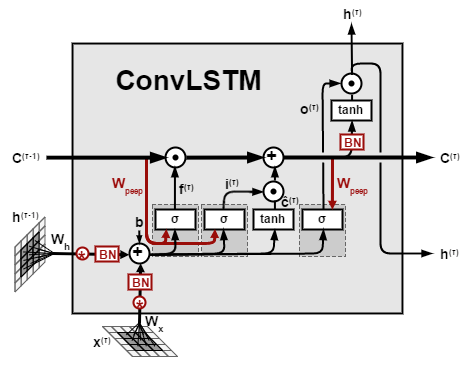

In [9]:
# 6. Conv-LSTM Model
class ConvLSTM(pl.LightningModule):
    def __init__(self, input_size, seq_length):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=50,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        x = x.permute(0, 2, 1)  # Conv1d expects (batch, features, seq)
        x = self.conv(x)
        x = x.permute(0, 2, 1)  # Back to (batch, seq, features)
        _, (h_n, _) = self.lstm(x)
        out = self.linear(h_n[-1])
        return out.squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# **Training**

In [17]:
# 7. Training
model = ConvLSTM(input_size=X_train.shape[2], seq_length=SEQ_LENGTH)
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        pl.callbacks.ModelCheckpoint(monitor='val_loss')
    ]
)
trainer.fit(
    model,
    DataLoader(train_dataset, batch_size=32, shuffle=True),
    DataLoader(val_dataset, batch_size=32)
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | conv   | Sequential | 1.8 K  | train
1 | lstm   | LSTM       | 43.6 K | train
2 | linear | Linear     | 51     | train
----------------------------------------------
45.4 K    Trainable params
0         Non-trainable params
45.4 K    Total params
0.182     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **Testing**

In [18]:
# 8. Test Evaluation
test_loader = DataLoader(test_dataset, batch_size=32)
trainer.test(model, test_loader)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   4.177722803433426e-05   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.177722803433426e-05}]

# **Evaluating**

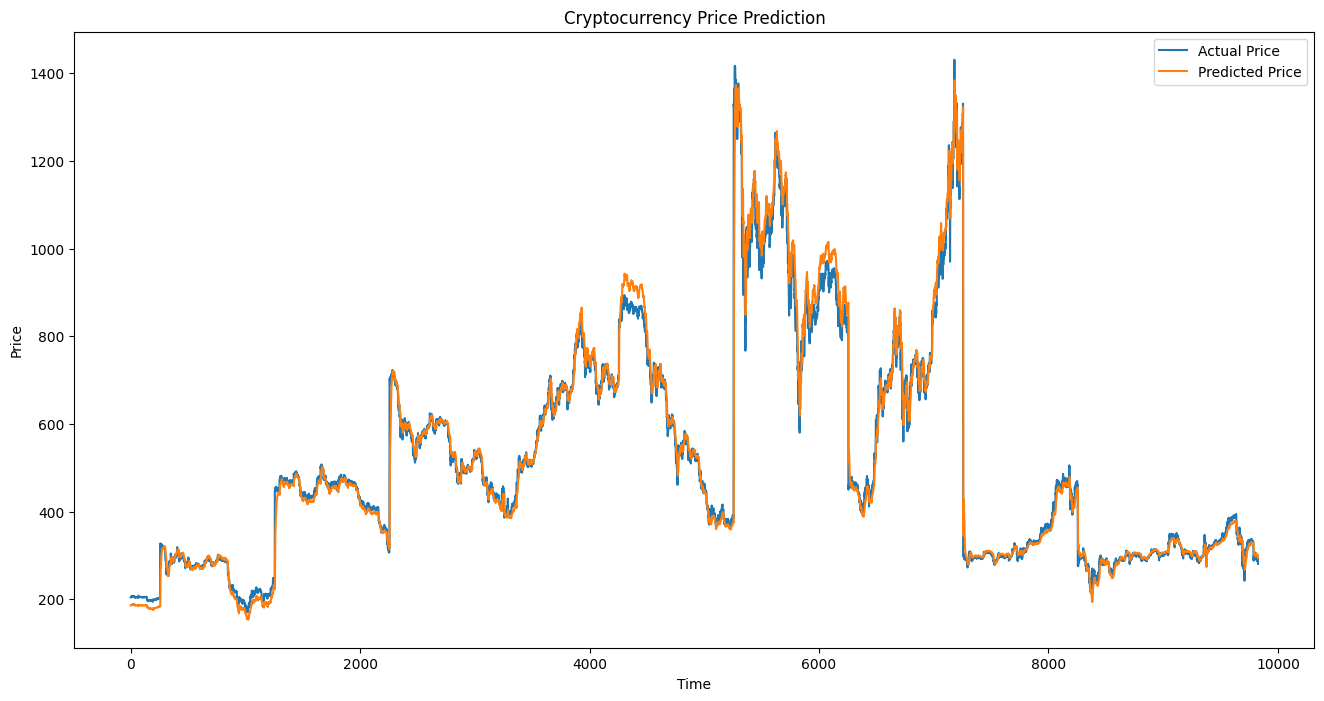

In [19]:
# 9. Plot Results
def inverse_transform(y):
    dummy = np.zeros((len(y), df.shape[1]))
    dummy[:, 3] = y
    return scaler.inverse_transform(dummy)[:, 3]

with torch.no_grad():
    model.eval()
    test_preds = model(torch.tensor(X_test, dtype=torch.float32))

actual_prices = inverse_transform(y_test)
predicted_prices = inverse_transform(test_preds.numpy())

plt.figure(figsize=(16,8))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()